<a href="https://colab.research.google.com/github/mark-polo/machine-learning/blob/main/Smile_detecting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone "https://github.com/mark-polo/Kaggle-competitions.git"

Cloning into 'Kaggle-competitions'...
remote: Enumerating objects: 31701, done.
remote: Counting objects: 100% (13246/13246), done.
remote: Compressing objects: 100% (13154/13154), done.
remote: Total 31701 (delta 95), reused 13242 (delta 92), pack-reused 18455
Receiving objects: 100% (31701/31701), 943.12 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Checking out files: 100% (32062/32062), done.


In [ ]:
! git clone "https://github.com/opencv/opencv.git"

Cloning into 'opencv'...
remote: Enumerating objects: 310492, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 310492 (delta 18), reused 45 (delta 13), pack-reused 310431
Receiving objects: 100% (310492/310492), 498.11 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (216161/216161), done.
Checking out files: 100% (7248/7248), done.


In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

from PIL import Image

In [ ]:
SIZE = (60,60)
SHAPE = (60,60,3)
units = 2

dataset = "/content/Kaggle-competitions/smile-not-smile"

In [ ]:
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

df = pd.concat([filepaths, labels], axis=1)

In [ ]:
dfn = df[df["Label"] != "test"].copy()

In [ ]:
dfn

,Filepath,Label
12030,/content/Kaggle-competitions/smile-not-smile/n...,non_smile
12031,/content/Kaggle-competitions/smile-not-smile/n...,non_smile
12032,/content/Kaggle-competitions/smile-not-smile/n...,non_smile
12033,/content/Kaggle-competitions/smile-not-smile/n...,non_smile
12034,/content/Kaggle-competitions/smile-not-smile/n...,non_smile
...,...,...
13228,/content/Kaggle-competitions/smile-not-smile/s...,smile
13229,/content/Kaggle-competitions/smile-not-smile/s...,smile
13230,/content/Kaggle-competitions/smile-not-smile/s...,smile
13231,/content/Kaggle-competitions/smile-not-smile/s...,smile


In [ ]:
train, valid = train_test_split(dfn, test_size=0.3, random_state=42)

In [ ]:
train_transformed_idg = ImageDataGenerator(
        rescale=1 / 255.0,
        shear_range=0.05,
        width_shift_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

train_idg = ImageDataGenerator(        
        rescale=1 / 255.0,
        rotation_range=20,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

valid_idg = ImageDataGenerator(rescale= 1 / 255.0)

In [ ]:
train_transformed = train_transformed_idg.flow_from_dataframe(
                                                  dataframe = train,
                                                  target_size = SIZE,
                                                  batch_size = 32,
                                                  class_mode = "categorical",
                                                  seed = 42,
                                                  x_col = 'Filepath',
                                                  y_col = 'Label',
                                                  shuffle = True)
train_original = train_idg.flow_from_dataframe(
                                     dataframe=train,
                                     target_size= SIZE,
                                     batch_size = 32,
                                     class_mode = "categorical",
                                     x_col='Filepath',
                                     y_col='Label',
                                     shuffle=False)

validation = valid_idg.flow_from_dataframe(
                                     dataframe=valid,
                                     target_size= SIZE,
                                     batch_size = 32,
                                     x_col='Filepath',
                                     y_col='Label',
                                     class_mode = "categorical",
                                     shuffle=False)

Found 842 validated image filenames belonging to 2 classes.
Found 842 validated image filenames belonging to 2 classes.
Found 361 validated image filenames belonging to 2 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=SHAPE,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    pretrained_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(units, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 19)                2451      
                                                        

In [ ]:
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True)

In [ ]:
chekpoint_file = "/content/chekpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(chekpoint_file)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=chekpoint_file,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
history = model.fit(train_transformed,
                                 epochs=30,
                                 steps_per_epoch = len(train_original),
                                 validation_data = validation,
                                 callbacks=[early_stopping, cp_callback],
                                 validation_steps = int(0.25*len(validation)))

Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.5036 - auc_1: 0.5324
Epoch 1: saving model to /content/chekpoint/cp.ckpt
27/27 [==============================] - 11s 243ms/step - loss: 0.7145 - accuracy: 0.5036 - auc_1: 0.5324 - val_loss: 0.6935 - val_accuracy: 0.4375 - val_auc_1: 0.5342
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.5629 - auc_1: 0.5995
Epoch 2: saving model to /content/chekpoint/cp.ckpt
27/27 [==============================] - 4s 153ms/step - loss: 0.6780 - accuracy: 0.5629 - auc_1: 0.5995 - val_loss: 0.6914 - val_accuracy: 0.4583 - val_auc_1: 0.5356
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.5819 - auc_1: 0.6158
Epoch 3: saving model to /content/chekpoint/cp.ckpt
27/27 [==============================] - 4s 150ms/step - loss: 0.6709 - accuracy: 0.5819 - auc_1: 0.6158 - val_loss: 0.7160 - val_accuracy: 0.4271 - val_auc_1: 0.5320
Epoch 4/30
2

In [ ]:
model.evaluate(validation)

12/12 [==============================] - 1s 99ms/step - loss: 0.4588 - accuracy: 0.7867 - auc_1: 0.8709


[0.45875465869903564, 0.7867035865783691, 0.8709033727645874]

Text(0.5, 1.0, 'Loss Curves')

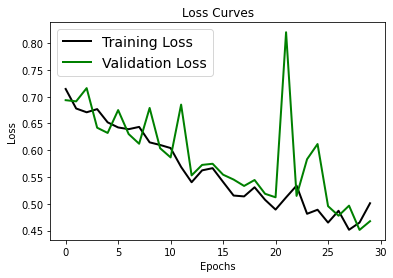

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

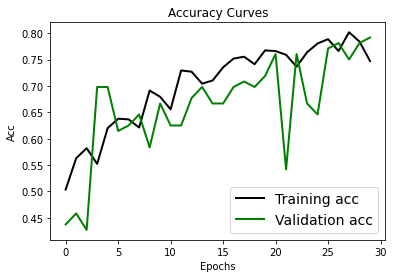

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training acc', 'Validation acc'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Acc', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Text(0.5, 1.0, 'AUC')

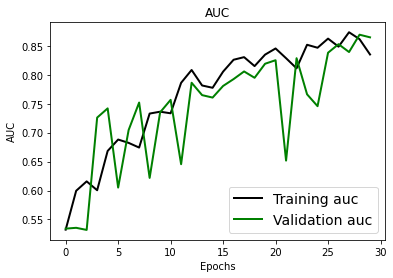

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(history.history['auc_1'], 'black', linewidth=2.0)
plt.plot(history.history['val_auc_1'], 'green', linewidth=2.0)
plt.legend(['Training auc', 'Validation auc'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('AUC', fontsize=10)
plt.title('AUC', fontsize=12)

In [ ]:
model.save("smile.h5")

# **Time to using cv2**

Unfortunatelly in colab can't use VideoCapture , however u can run all that code on u own machine 

In [ ]:
model_cv = load_model("/content/smile.h5")

In [ ]:
labels_dict={0:'not smile',1:'smile'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 2

webcam = cv.VideoCapture(0)

In [ ]:
cascade = cv.CascadeClassifier("/content/opencv/data/haarcascades/haarcascade_frontalcatface.xml")

In [ ]:
while True:
    (rval, im) = webcam.read()
    im=cv.flip(im,1,1) #Flip to act as a mirror

    w = int(im.shape[1] // size)
    h = int(im.shape[0] // size)

    dimensions = (w , h)
    mini = cv.resize(im, dimensions)

    faces = cascade.detectMultiScale(mini)

    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)

        face_img = im[y:y+h, x:x+w]
        resized=cv.resize(face_img,(60,60))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,60,60,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
      
        cv.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv.putText(im, labels_dict[label], (x, y-10),cv.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    cv2_imshow(im)
    key = cv.waitKey(10)
    if key == 27: #The Esc key
        break

webcam.release()

cv.destroyAllWindows()

AttributeError: ignored